In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder

In [2]:
#getting the dataset
dataset = pd.read_csv('windData.csv', header=0)
values = dataset.values
#encoding wind direction
encoder = LabelEncoder()
values[:, 2] = encoder.fit_transform(values[:,2])
#ensure all data is float
values = values.astype('float32')

In [3]:
#function to convert series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
#data preprocessing by normalizing
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [6]:
#converting data to supervised
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
reframed.columns = ['Temp', 'Dew', 'WindDir', 'Humidity', 'press', 'windSpeed', 'fwindSpeed'] 

In [7]:
len(reframed)

159024

In [8]:
#splitting, 3 years of training and 2 years for testing
#scaledpd = DataFrame(scaled)
#scaledpd.dropna(inplace = True)
values = reframed.values
n_train_hours = 120000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [10]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(120000, 1, 6) (120000,) (39024, 1, 6) (39024,)


In [12]:
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-09, amsgrad=False, name='Adam')
model.compile(loss='mae', optimizer= optimizer)

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 120000 samples, validate on 39024 samples
Epoch 1/15
120000/120000 - 19s - loss: 0.0046 - val_loss: 0.0043
Epoch 2/15
120000/120000 - 16s - loss: 0.0034 - val_loss: 0.0033
Epoch 3/15
120000/120000 - 16s - loss: 0.0030 - val_loss: 0.0029
Epoch 4/15
120000/120000 - 16s - loss: 0.0028 - val_loss: 0.0029
Epoch 5/15
120000/120000 - 15s - loss: 0.0028 - val_loss: 0.0029
Epoch 6/15
120000/120000 - 16s - loss: 0.0028 - val_loss: 0.0029
Epoch 7/15
120000/120000 - 17s - loss: 0.0028 - val_loss: 0.0029
Epoch 8/15
120000/120000 - 17s - loss: 0.0028 - val_loss: 0.0029
Epoch 9/15
120000/120000 - 17s - loss: 0.0028 - val_loss: 0.0029
Epoch 10/15
120000/120000 - 17s - loss: 0.0028 - val_loss: 0.0029
Epoch 11/15
120000/120000 - 17s - loss: 0.0028 - val_loss: 0.0029
Epoch 12/15
120000/120000 - 16s - loss: 0.0028 - val_loss: 0.0028
Epoch 13/15
120000/120000 - 16s - loss: 0.0028 - val_loss: 0.0029
Epoch 14/15
120000/120000 - 19s - loss: 0.0028 - val_loss: 0.0028
Epoch 15/15
120000/120000 - 18s - 

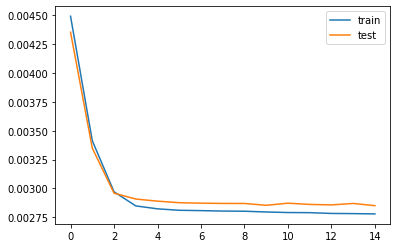

In [49]:
#plotting to check loss
from  matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [15]:
# invert scaling for forecast
from numpy import concatenate

In [16]:
inv_yhat = concatenate((test_X[:, :-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [17]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [18]:
#error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#print('Individual RMSE: ')
#indrmse = [];
#for i in range(len(inv_y)):
 #   rms = sqrt(float(abs(inv_y[i]-inv_yhat[i])))
  #  indrmse.append(rms)
#pyplot.plot(indrmse)

Test RMSE: 2.199


In [24]:
inv_yhat[:20]

array([6.1981177, 6.625126 , 6.567989 , 6.699255 , 3.9225197, 4.177535 ,
       3.4486682, 2.8072827, 2.8072827, 3.5931087, 1.8393729, 1.8405869,
       1.8405869, 1.8405869, 1.7001808, 1.7001808, 1.7001808, 1.7001808,
       1.7001808, 2.612975 ], dtype=float32)

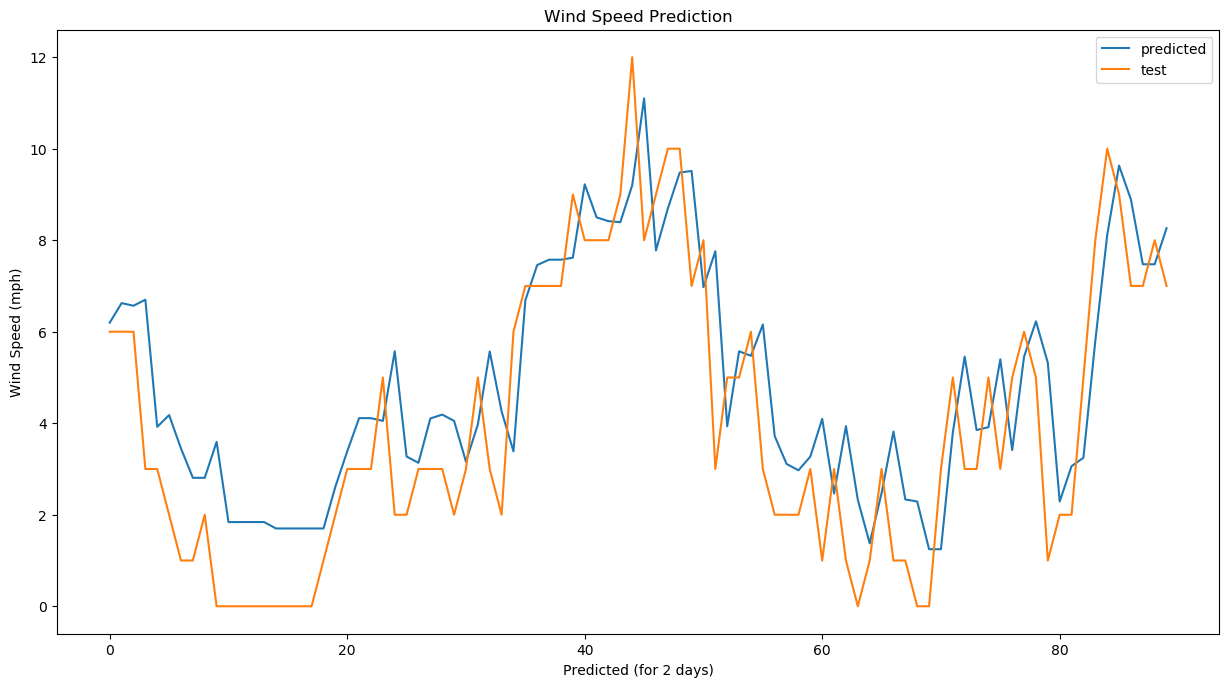

In [63]:
from  matplotlib import pyplot
pyplot.figure(num=None, figsize=(15, 8), dpi=100, facecolor='w', edgecolor='k')
pyplot.title("Wind Speed Prediction")
pyplot.plot(inv_yhat[:90], label='predicted')
pyplot.plot(inv_y[:90],label='test')
pyplot.xlabel("Predicted (for 2 days)")
pyplot.ylabel("Wind Speed (mph)")
image = pyplot.gcf()
pyplot.legend()

In [64]:
image.savefig('windSpeedPredicted.png')